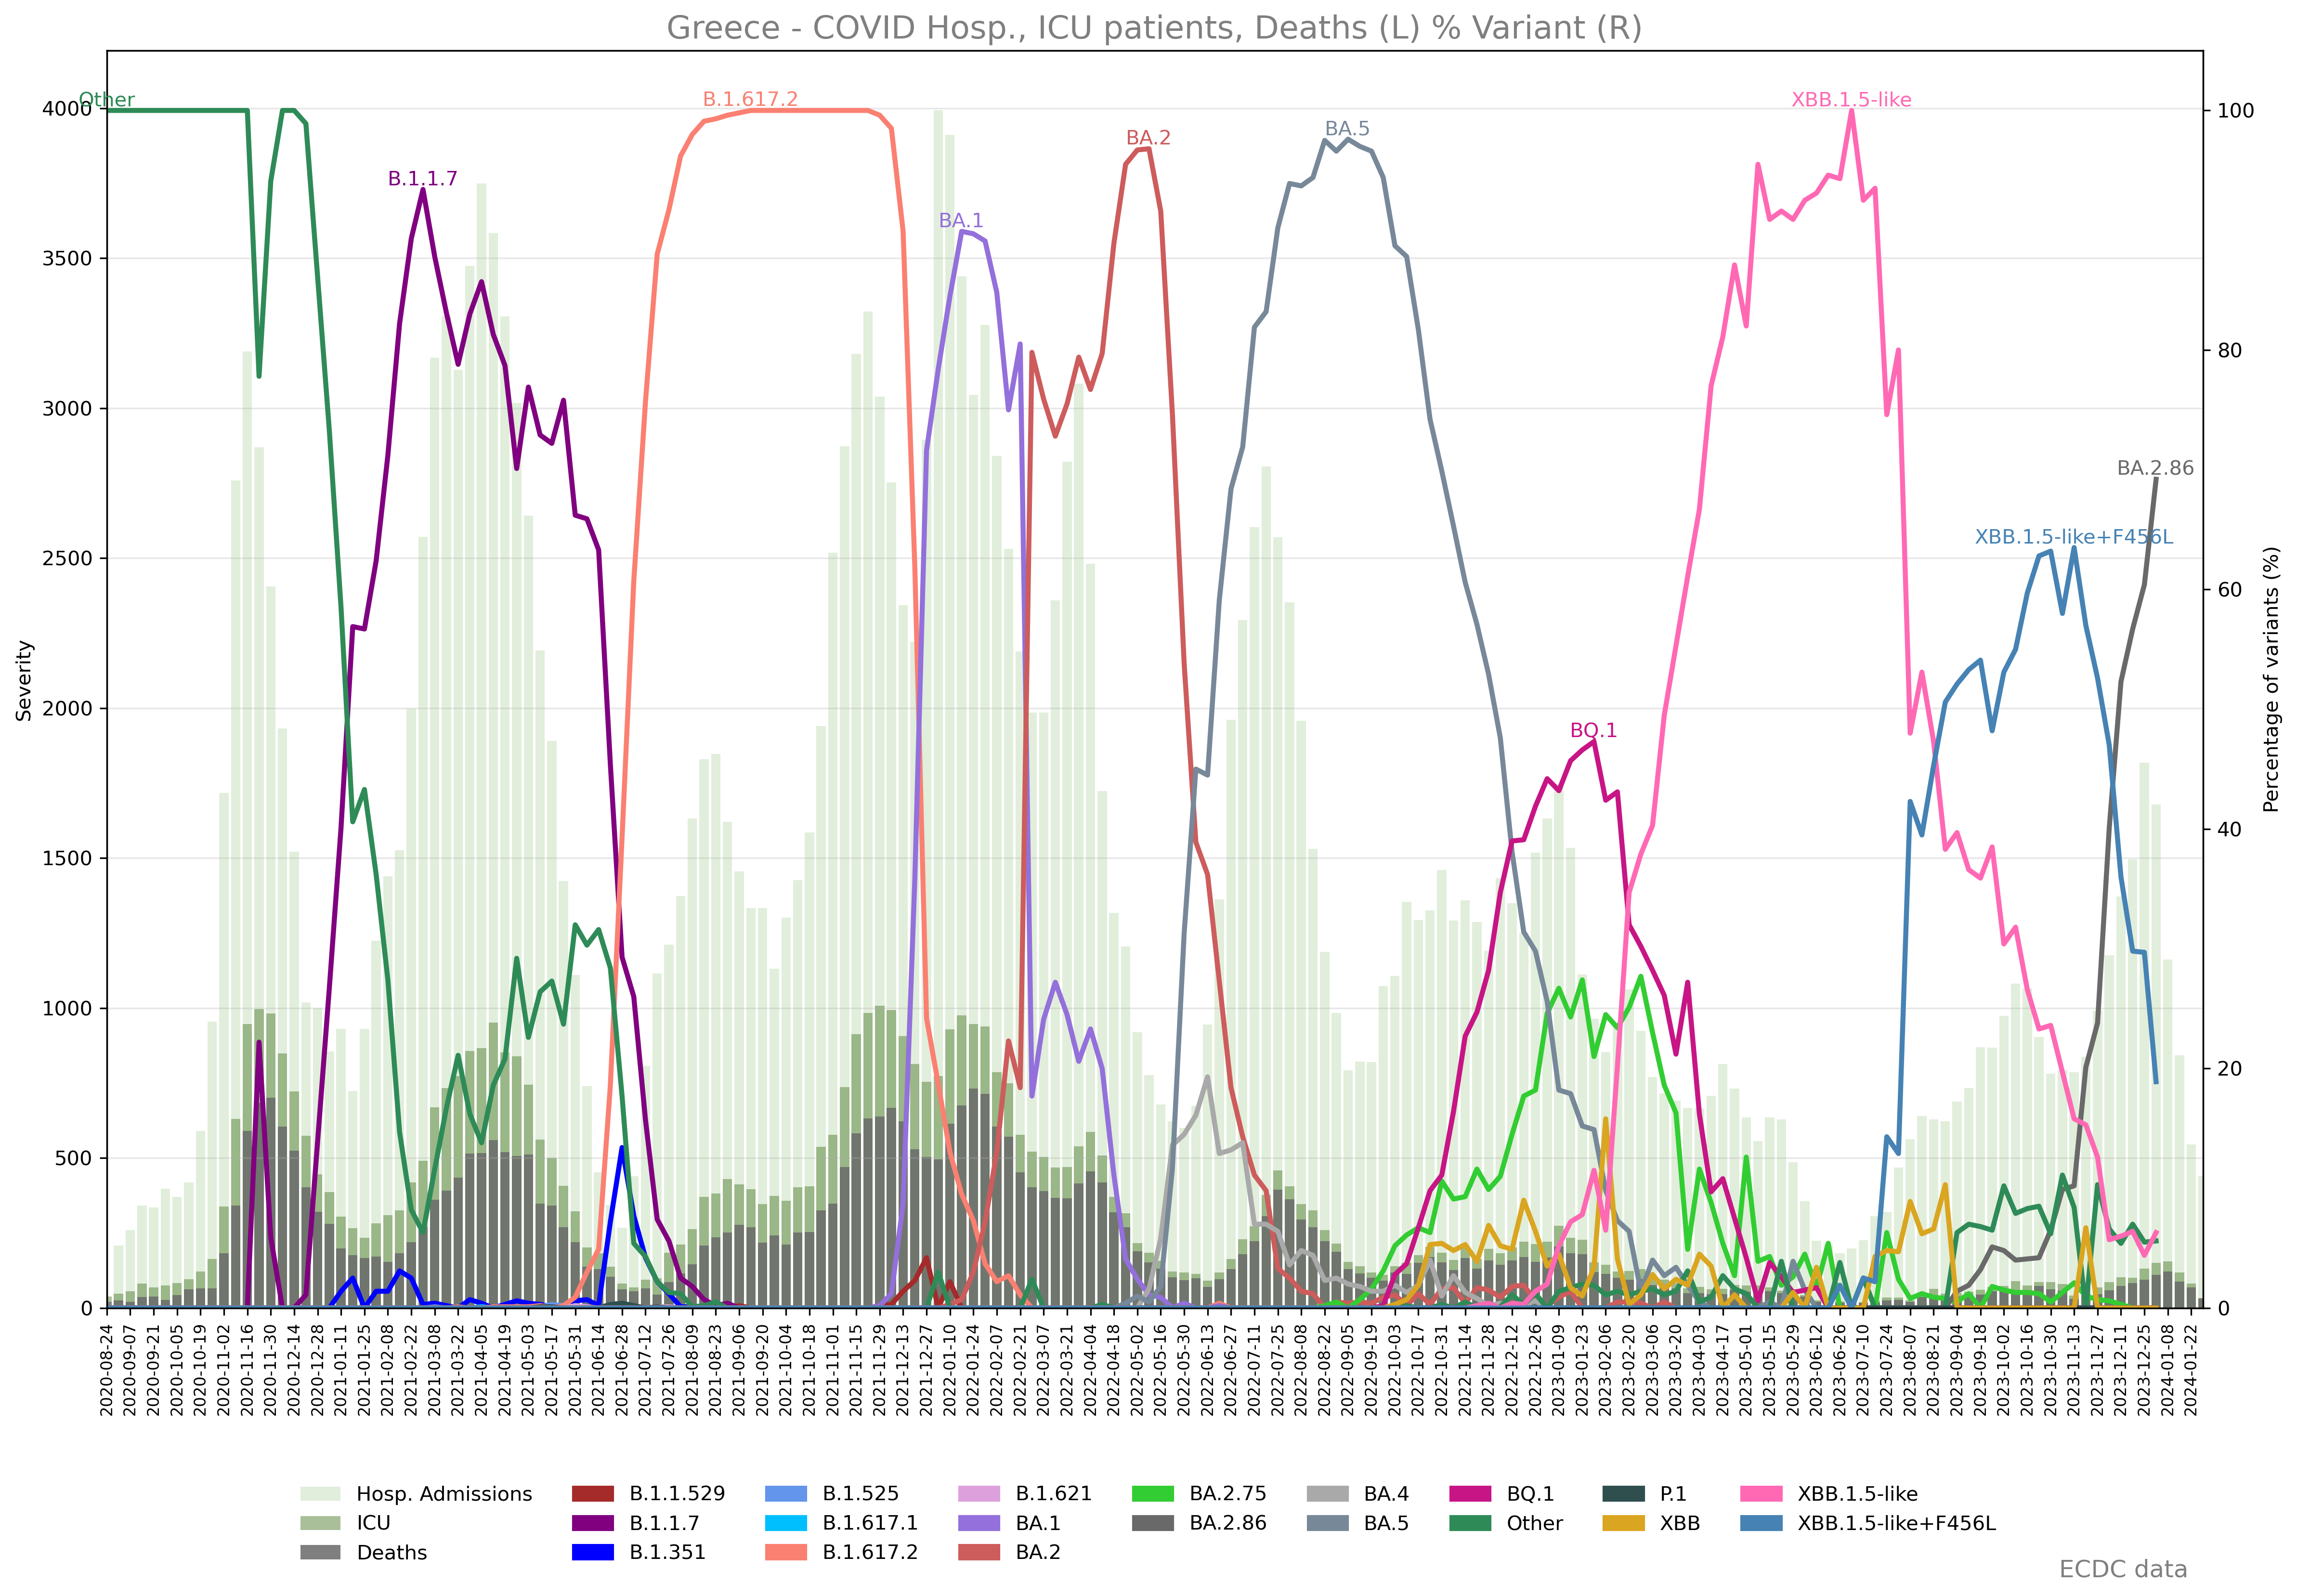

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np
import random

#country
country = "Greece"

# Read variants data from CSV
variants_df = pd.read_csv('variants.csv')

# Filter variants data for Greece and proportion
variants_df = variants_df[(variants_df['countryname'] == country) & 
                          (variants_df['pathogen'] == 'SARS-CoV-2') &
                          (variants_df['indicator'] == 'proportion')]

# Aggregate values (sum) for duplicate entries
variants_df = variants_df.groupby(['yearweek', 'variant']).agg({'value': 'sum'}).reset_index()

# Pivot to wide format
variants = variants_df.pivot(index='yearweek', columns='variant', values='value').fillna(0)

# Convert ISO week date to YYYY-MM-DD format
variants.index = pd.to_datetime(variants.index + '-1', format='%G-W%V-%u').map(lambda x: x.strftime('%Y-%m-%d'))
# Filter out data before '2020-09-20'
variants = variants.loc['2020-08-20':]

#-----------------------------------------------------------------------------------------

def is_bright(color, threshold=0.7):
    # Calculate the luminance of the color
    luminance = 0.2126 * color[0] + 0.7152 * color[1] + 0.0722 * color[2]
    # Check if the luminance is above the threshold
    return luminance > threshold

def color_distance(color1, color2):
    # Calculate Euclidean distance between two colors in RGB space
    return np.linalg.norm(np.array(color1) - np.array(color2))

def random_color_generator(num_colors, min_distance=0.2, seed=None):
    if seed is not None:
        random.seed(seed)
    colors = []
    available_colors = list(mcolors.CSS4_COLORS.keys())  # Use keys to get color names directly
    while len(colors) < num_colors:
        color_name = random.choice(available_colors)
        color_rgb = mcolors.to_rgb(color_name)
        if not is_bright(color_rgb):
            # Check distance from other colors
            if all(color_distance(color_rgb, mcolors.to_rgb(c)) > min_distance for c in colors):
                colors.append(color_name)
    return colors


# Get the number of random colors using a seed
num_colors = len(variants.columns)
variant_colors = random_color_generator(num_colors, seed=1123)

#-----------------------------------------------------------------------------------------

# Read non-sentinel detections data from CSV
severity_df = pd.read_csv('nonSentinelSeverity.csv')


# Filter severity data for Greece, SARS-CoV-2, and indicators hospitaladmissions, ICUadmissions, and deaths
severity_df = severity_df[(severity_df['countryname'] == country) &
                          (severity_df['pathogen'] == 'SARS-CoV-2') &
                          (severity_df['age'] == 'total') &
                          (severity_df['indicator'].isin(['hospitaladmissions', 'ICUadmissions', 'deaths']))]

# Convert ISO week date to YYYY-MM-DD format
severity_df['date'] = pd.to_datetime(severity_df['yearweek'] + '-1', format='%G-W%V-%u').map(lambda x: x.strftime('%Y-%m-%d'))

# Reset the index to avoid duplicate entries
severity_df.reset_index(drop=True, inplace=True)

# Pivot severity data to wide format
severity_pivot = severity_df.pivot(index='date', columns='indicator', values='value').fillna(0)
# Filter out data before '2020-09-20'
severity_pivot = severity_pivot.loc['2020-08-20':]

# Reindex variants to match the index of severity_pivot
variants = variants.reindex(severity_pivot.index)

#-----------------------------------------------------------------------------------------

# Plotting...
#fig, ax1 = plt.subplots(figsize=(16, 10))
fig, ax1 = plt.subplots(figsize=(16, 10), dpi=300)

# Plot cases as bars
cases_bar = ax1.bar(np.arange(len(severity_pivot.index)), severity_pivot['hospitaladmissions'], color='#C5DFB9', alpha=0.5, label='Hosp. Admissions')

# Plot ICU as bars above cases and deaths bars
icu_bar = ax1.bar(np.arange(len(severity_pivot.index)), severity_pivot['ICUadmissions'], color='#548135', alpha=0.5, label='ICU', bottom=severity_pivot['deaths'])

# Plot deaths as bars above cases bars
deaths_bar = ax1.bar(np.arange(len(severity_pivot.index)), severity_pivot['deaths'], color='black', alpha=0.5, label='Deaths')

# Create a secondary y-axis for variants
ax2 = ax1.twinx()

# Plot variants as lines
for i, variant in enumerate(variants.columns):
    line = ax2.plot(variants.index, variants[variant], marker='', linestyle='-', color=variant_colors[i], label=f'{variant}', linewidth=2.5)

    # Add text above the lines that are > 40%
    max_value = variants[variant].max()
    if max_value > 40:
        max_index = variants[variants[variant] == max_value].index[0]
        ax2.text(max_index, max_value, f'{variant}', color=variant_colors[i], ha='center', va='bottom', fontsize=10)

# Set the primary y-axis label
ax1.set_ylabel('Severity')

# Set the secondary y-axis label
ax2.set_ylabel('Percentage of variants (%)')
ax2.tick_params(axis='y')

# Set y-axis limits for both axes
ax1.set_ylim(bottom=0)
ax2.set_ylim(bottom=0)

#print(severity_pivot['deaths'])

# Adding variants at the bottom of the chart
# Show only weekly ticks and rotate them vertically
ax1.set_xticks(np.arange(0, len(severity_pivot.index), 2))  # Adjust step size for x-axis ticks
ax1.set_xticklabels(severity_pivot.index[::2], rotation='vertical', fontsize=8)  # Adjust font size for x-axis labels

# Set x-axis limits using numeric values instead of datetime objects
dates = pd.to_datetime(severity_pivot.index)
ax1.set_xlim(0, len(dates) - 1)

# Remove vertical grid lines
ax1.grid(axis='y', alpha=0.3, zorder=0)  # Adjust alpha for transparency and zorder to place behind bars and lines

# Create a legend for variants below the x-axis
variant_patches = []
for i, (variant, color) in enumerate(zip(variants.columns, variant_colors)):
    variant_patches.append(plt.Rectangle((0, 0), 1, 1, color=color, label=variant))


# Add a title above the chart
plt.title(f'{country} - COVID Hosp., ICU patients, Deaths (L) % Variant (R)', loc='center', fontsize=16, fontname='DejaVu Sans', alpha=0.5)

# Create a legend for variants and cases
legend_handles = [cases_bar, icu_bar, deaths_bar] + variant_patches

# Split variant patches into rows with a maximum of 9 items per row
max_per_row = 9
num_cols = min(max_per_row, len(variant_patches))
# Create the legend with the appropriate number of columns
legend = fig.legend(handles=legend_handles, loc='lower center', bbox_to_anchor=(0.5, -0.1), ncol=num_cols, frameon=False)

# Add text at the bottom right corner
fig.text(0.95, -0.1, 'ECDC data', ha='right', va='bottom', fontsize=12, color='gray')


# Adjust legend position
legend.get_frame().set_linewidth(0.0)
plt.subplots_adjust(bottom=0.1)  # Adjust bottom parameter to leave space for the legend

# Adjust layout to accommodate legend
plt.tight_layout()
plt.show()
